In [1]:
# @title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex tfds-nightly tf-nightly einops")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

### Package Preamble

In [5]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

# datasets
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

We're going to using the MNIST dataset. It's a simple dataset with a single channel image and `28x28`. So overall it's `60Kx28x28x1`.

We're going to use the `numpy` standard for the images.

`B,H,W,C`

where:
* `B` - batch size
* `H` - height 
* `W` - width
* `C` - channels


## Full Example

### Data

In [6]:
# normalize images
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

In [52]:
# DATA, CIFAR10
ds, ds_info = tfds.load(
    "cifar10", split="train", as_supervised=True, shuffle_files=True, with_info=True
)


ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# take some examples
B = 50_000

# take 10 samples from the dataset
ds_sample = ds.take(B)

In [53]:
# extract all images
X = [x[0] for x in tfds.as_numpy(ds_sample)]

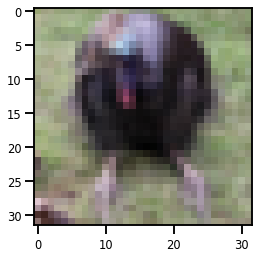

In [54]:
plt.imshow(X[0])

In [55]:
# stack them in a new batch axes
X = np.stack(X).astype(np.float32)

print(X[0].min(), X[0].max())

# add some noise
X += 0.001 * np.random.rand(*X.shape)
X.shape

0.007843138 0.90588236


(50000, 32, 32, 3)

In [56]:
# normalize
from sklearn.preprocessing import StandardScaler

X = X.reshape(-1, 1)

x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

X = X.reshape((B, 32, 32, 3))

# convert to jax array
X = jnp.array(X)

X.shape

(50000, 32, 32, 3)

In [57]:
def rescale_image(img, scaler):
    H, W, C = img.shape

    img = img.reshape((1, H * W * C))

    img = scaler.inverse_transform(img)

    img = img.reshape((H, W, C))
    return img

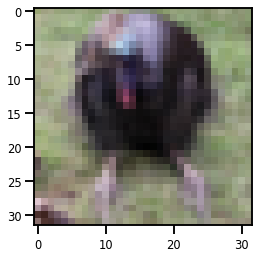

In [58]:
plt.imshow(rescale_image(X[0], x_scaler))

<ipython-input-59-a69cf7dab745>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


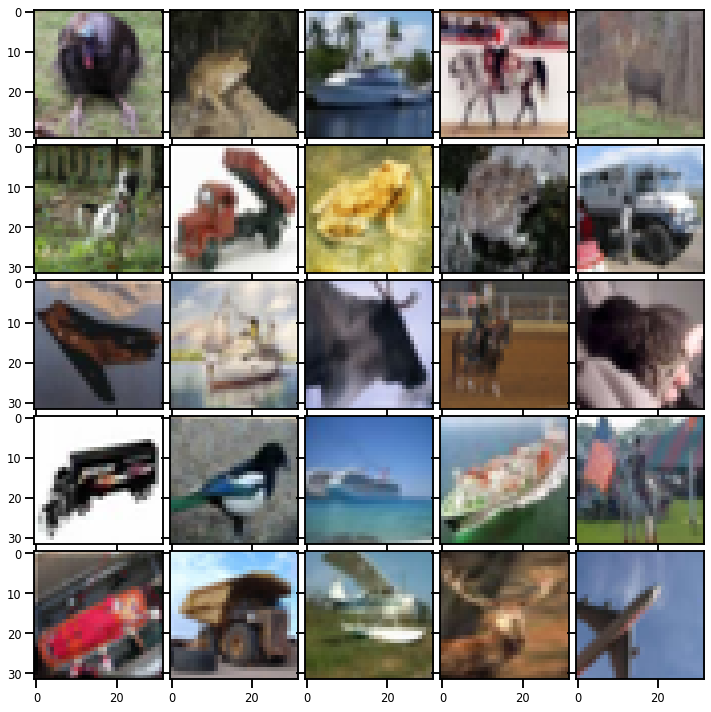

In [59]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X[i], x_scaler)

    ax.imshow(img)

plt.tight_layout()
plt.show()

### Model

In [60]:
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.block import InitRBIGBlock
import corner
from rbig_jax.transforms.reshape import Squeeze

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(jnp.sqrt(X.shape[0]))


# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
)

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize marginal gaussianization
eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = InitRBIGBlock(
    uni_uniformize, rot_transform, eps
)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

### Model Training

In [61]:
# initialize layer
reshape_layer = Squeeze((2, 2), None)

# initialize params and functions
_, f, inv_f = reshape_layer((), X.shape)

#
# transform data
X_t, _ = f((), X)

X_t.shape

(50000, 768, 2, 2)

In [ ]:
# layer params
filter_shapes = [(2, 2), (4, 4), (8, 8), (16, 16), (32, 32)]
n_layers = [10, 20, 30, 40, 50]
# n_layers = 100
params = []
losses = []
ilayer = 0
X_g = X
plot_layers = True

if plot_layers:
    fig = corner.corner(X_g.reshape((B, 32 * 32 * 3))[:, :5])

with tqdm.tqdm(list(zip(filter_shapes, n_layers))) as pbar:

    for i_mscale, (ifilter, i_layers) in enumerate(pbar):

        #         pbar.set_description(f"Multiscale Level: {i_mscale+1}, Filter: {ifilter}")

        # initialize layer
        reshape_layer = Squeeze(ifilter, "spatial")

        # initialize params and functions
        _, f, inv_f = reshape_layer((), X.shape)

        # save functions
        ms_params = {"reshape_f": f, "reshape_invf": inv_f}

        # transform data
        X_g, _ = f((), X_g)

        pbar.set_description(
            f"Multiscale Level: {i_mscale+1}, Filter: {ifilter}"
            f", Size: ({X_g.shape[0]:_},{X_g.shape[1]:_})"
        )

        # Gaussianize
        layer_params = []

        while ilayer < i_layers:

            # compute
            X_g, ilayer_params = fit_transform_func_jitted(X_g)

            # increment
            ilayer += 1

            layer_params.append(ilayer_params)

        ms_params["rbig_params"] = layer_params

        # save dictionary of params
        params.append(ms_params)

        # invert multiscale
        X_g, _ = inv_f((), X_g)
        if plot_layers:
            fig = corner.corner(X_g.reshape((B, 32 * 32 * 3))[:, :5])

Multiscale Level: 5, Filter: (32, 32), Size: (150_000,1_024):  80%|████████  | 4/5 [09:41<02:27, 147.38s/it]

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax[0, 0].imshow(rescale_image(X[0], x_scaler))
ax[0, 1].imshow(X_g[0], cmap="gray")
ax[1, 0].hist(X[0].ravel(), bins=100, density=True, color="gray")
ax[1, 1].hist(X_g[0].ravel(), bins=100, density=True, color="gray")
plt.tight_layout()
plt.show()

### Inversion

1. Convert to Multiscale
2. Do Inverse Transformation
3. Invert to Original Scale
4. Repeat for all scales

In [ ]:
X_approx = X_g

with tqdm.tqdm(params[::-1]) as pbar:

    for i_ms_layer, iparam in enumerate(pbar):

        # Convert to Multiscale transformation
        X_approx, _ = iparam["reshape_f"]((), X_approx)

        # Loop Through RBIG (in reverse)
        for i_layer_param in reversed(iparam["rbig_params"]):

            # inverse transformation
            X_approx = inverse_f_jitted(i_layer_param, X_approx)

        # Undo to Multiscale transformation
        X_approx, _ = iparam["reshape_invf"]((), X_approx)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax[0, 0].imshow(rescale_image(X_approx[0], x_scaler))
ax[0, 1].imshow(rescale_image(X[0], x_scaler))
ax[1, 0].hist(X[0].ravel(), bins=100, density=True, color="gray")
ax[1, 1].hist(X_approx[0].ravel(), bins=100, density=True, color="gray")
plt.tight_layout()
plt.show()

In [ ]:
mse = jnp.mean((X_approx - X) ** 2)
print(f"MSE: {mse:.3e}")

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X_approx[i], x_scaler)
    ax.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

### Synthesis

In [ ]:
rng = np.random.RandomState(123)

X_g_samples = rng.randn(*X_g.shape)

In [ ]:
X_synth = X_g_samples

with tqdm.tqdm(params[::-1]) as pbar:

    for i_ms_layer, iparam in enumerate(pbar):

        # Convert to Multiscale transformation
        X_synth, _ = iparam["reshape_f"]((), X_synth)

        # Loop Through RBIG (in reverse)
        for i_layer_param in reversed(iparam["rbig_params"]):

            # inverse transformation
            X_synth = inverse_f_jitted(i_layer_param, X_synth)

        # Undo to Multiscale transformation
        X_synth, _ = iparam["reshape_invf"]((), X_synth)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax[0, 0].imshow(rescale_image(X[0], x_scaler))
ax[0, 1].imshow(rescale_image(X_synth[0], x_scaler))
ax[1, 0].hist(X[0].ravel(), bins=100, density=True, color="gray")
ax[1, 1].hist(X_synth[0].ravel(), bins=100, density=True, color="gray")
plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X_synth[i], x_scaler)
    ax.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()